# Notebook implementation of Pytorch lightning

This is an exercise I went through to understand and learn how to implement pytorch lightning. 
I generated a bunch of random points and fit a simple MLP to them using pytorch lightning.

In [1]:
import numpy as np
import pylab as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.distributed import DistributedSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, DeviceStatsMonitor
from lightning.pytorch import loggers as pl_loggers

First I used the pytorch dataset class to generate the random numbers. This can also be used if you're loading data from a file. 

This class is especially useful if you don't have enough memory to load all the data. In that case, you define pointers to the files in the init function, and then in the getitem function you load the data from the pointer. More info can be found on [Pytorch Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
class dataset_class(torch.utils.data.Dataset):
    def __init__(self, n=100, f_x=None, sigma=0.2):
        self.x = np.linspace(-2*np.pi, 2*np.pi, n)
        np.random.seed(0)
        self.y = f_x(self.x) + np.random.normal(loc=0, scale=sigma, size=n)
        self.x = self.x.reshape((n,1))
        self.y = self.y.reshape((n,1))
         
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx,:]

Next, the lightning data module class is used to generate training and validation data sets. 

When training with multiple GPUs, it is useful to know that the init function will run on all the GPUs. Here I use the dataset class defined above, but I didn't need to. I could have just generated the random points within the lightning data module and not used the dataset class. More info can be found on [Lightning Data Module](https://lightning.ai/docs/pytorch/stable/data/datamodule.html).

In [2]:
class data_module(pl.LightningDataModule):
    def __init__(self, n=100, f_x=None, sigma=0.2, batch_size=10, num_workers=1, train_size=0.8):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        generator1 = torch.Generator().manual_seed(42)
        toy_dataset = dataset_class(n=n, f_x=f_x, sigma=sigma)
        self.train_data, self.val_data = torch.utils.data.random_split(toy_dataset, [train_size, 1-train_size], generator=generator1)

        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=self.train_data,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True
        )
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=self.val_data,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True
        )
        


Here I define a simple MLP that is only a single linear layer if layer_sizes is a list of length 1, and a normal non-linear network otherwise.

In [ ]:
class mlp(nn.Module):
    def __init__(self, input_dim=512, layer_sizes=[512,512,128]):
        super().__init__()                
        self.layers = nn.ModuleList()
        
        if len(layer_sizes) == 1:
            self.layers.append(nn.Linear(input_dim, layer_sizes[0]))
        else:
            self.layers.append(nn.Linear(input_dim, layer_sizes[0]))
            for i in range(1,len(layer_sizes)):
                self.layers.append(nn.ReLU(False))
                self.layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
        
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x   

The lightning module is where the main model is defined. More info can be found on [Lightning Module](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

In [3]:
class mlp_lightning(pl.LightningModule):
    def __init__(self, mlp, lr):
        super().__init__()
        self.mlp = mlp
        self.lr = lr
        
    def forward(self, x):
        x = self.mlp(x)
        return x
    
    def mse_loss(self, y_pred, y_true):
        loss_fn = torch.nn.MSELoss()
        return loss_fn(y_pred, y_true)
    
    def training_step(self, batch_data, batch_idx):
        batch_x, batch_y = batch_data
        batch_preds = self.forward(batch_x)
        loss = self.mse_loss(batch_preds, batch_y)
        self.log("training_loss", loss, on_epoch=True, sync_dist=True)

        return loss
        
    def validation_step(self, batch_data, batch_idx):
        batch_x, batch_y = batch_data
        batch_preds = self.forward(batch_x)
        loss = self.mse_loss(batch_preds, batch_y)
        self.log("valid_loss", loss, on_epoch=True, sync_dist=True)
        return loss
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-05)
        return optim


In [5]:
def f_x(x):
    return np.sin(x) + x/5

In [ ]:
batch_size = 10
n = 100
train_size = 0.5
data_module_instance = data_module(n=n, f_x=f_x, sigma=0.2, batch_size=batch_size, train_size=train_size)

mlp_instance = mlp(input_dim=1, layer_sizes=[16,32,16,1])
lr = 1e-2
lightning_model = mlp_lightning(mlp_instance, lr)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="./lightning_logs",\
                                        name=f'simple_test')

trainer = pl.Trainer(accelerator='cpu', devices=1, min_epochs=1, max_epochs=1000, precision='64',\
                     log_every_n_steps=1, default_root_dir="./",\
                     strategy='ddp_notebook', logger=tb_logger, enable_progress_bar=False)
#trainer.fit(simclr_model, train_data, valid_data)
trainer.fit(lightning_model, data_module_instance)


Here I use torch.Generator() to make sure that the train/test split is the same as the one in the dataset class.

In [7]:
np.random.seed(0)
x = np.linspace(-2*np.pi, 2*np.pi, n)
y = f_x(x) + np.random.normal(loc=0, scale=0.2, size=n)

generator1 = torch.Generator().manual_seed(42)
x_train_set, x_val_set = torch.utils.data.random_split(x, [train_size, 1-train_size], generator=generator1)
x_train = x[x_train_set.indices]
x_val = x[x_val_set.indices]
y_train = y[x_train_set.indices]
y_val = y[x_val_set.indices]

In [8]:
y_pred = lightning_model.forward(torch.from_numpy(x.reshape(n,1)).float()).detach().numpy().squeeze()

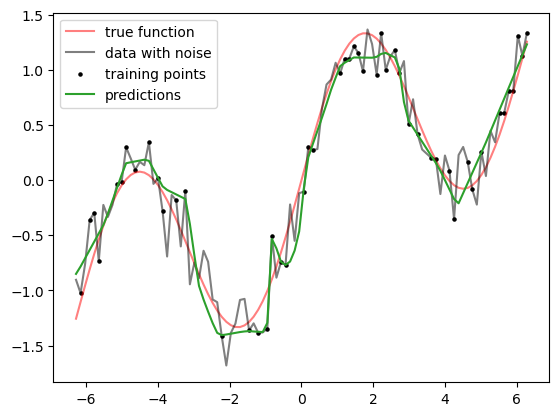

In [9]:
fig, ax = plt.subplots()

ax.plot(x, f_x(x), label='true function', c='r', alpha=0.5)
ax.plot(x, y, c='k', alpha=0.5, label='data with noise')
ax.scatter(x_train, y_train, s=5, c='k', label='training points')
ax.plot(x, y_pred, label='predictions', c='tab:green')
ax.legend()
